In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd

import numpy as np
from dateutil.parser import parse

In [19]:
with open("C:/Users/mjwan/Documents/Jobs/applied_8_9_2022.txt", "r", encoding="utf-8") as file:
    text = file.readlines()

In [20]:
# filter job lines
date_dict = {}

for line in text:
    try: 
        date = parse(line)
        date_dict[date] = []
    except:
        if ":" in line:
            date_dict[date].append(line)

jobs_by_date = [item for sublist in [list(map(lambda vv: (k, vv), v)) for k, v in date_dict.items()] for item in sublist]

In [21]:
df = pd.DataFrame(jobs_by_date, columns=["Date_Applied", "Line"])

In [22]:
df["Line"]

0         NYT: Data Insights (Games) - wordleBitch123$\n
1      SPOTIFY: Data Scientist, Spotify for Artists =...
2            DOW JONES: Data Analyst - wordleBitch123$\n
3      MANTECH: Data Science/Analytics New Graduate -...
4                         OSCAR HEALTH: Data Scientist\n
                             ...                        
268    HORNBLOWER GROUP: Data Analyst, eCommerce - wo...
269     PINTEREST: Integrity Analyst - wordleBitch123$\n
270                 MyFitnessPal: Data Quality Analyst\n
271                NUNA: Health Data Analyst Associate\n
272                 HIREMATCH: Jr. Data Analyst ==> SCAM
Name: Line, Length: 273, dtype: object

In [23]:
df["Company"] = df["Line"].str.strip().str.split(":").apply(lambda l: l[0].strip())
df["Title"] = df["Line"].str.strip().str.split(":|w.+\$$|==>", regex=True).apply(lambda l: l[1].strip().title())
df["Result"] = df["Line"].str.strip().str.split("==>").apply(lambda l: l[1].strip().title() if len(l) > 1 else "No Response")
df["DOW"] = df["Date_Applied"].apply(lambda d: d.day_name())

In [24]:
# rejection PB is 37 minutes
df["Result"].value_counts(dropna=False)

No Response        172
Rejected            84
First Interview      7
Scam                 4
Contacted            3
Third Interview      2
Offer                1
Name: Result, dtype: int64

In [25]:
# industry of company
df

,Date_Applied,Line,Company,Title,Result,DOW
0,2022-08-09,NYT: Data Insights (Games) - wordleBitch123$\n,NYT,Data Insights (Games) -,No Response,Tuesday
1,2022-08-09,"SPOTIFY: Data Scientist, Spotify for Artists =...",SPOTIFY,"Data Scientist, Spotify For Artists",Rejected,Tuesday
2,2022-08-09,DOW JONES: Data Analyst - wordleBitch123$\n,DOW JONES,Data Analyst -,No Response,Tuesday
3,2022-08-09,MANTECH: Data Science/Analytics New Graduate -...,MANTECH,Data Science/Analytics Ne,No Response,Tuesday
4,2022-08-09,OSCAR HEALTH: Data Scientist\n,OSCAR HEALTH,Data Scientist,No Response,Tuesday
...,...,...,...,...,...,...
268,2022-12-31,"HORNBLOWER GROUP: Data Analyst, eCommerce - wo...",HORNBLOWER GROUP,"Data Analyst, Ecommerce -",No Response,Saturday
269,2022-12-31,PINTEREST: Integrity Analyst - wordleBitch123$\n,PINTEREST,Integrity Analyst -,No Response,Saturday
270,2022-12-31,MyFitnessPal: Data Quality Analyst\n,MyFitnessPal,Data Quality Analyst,No Response,Saturday
271,2022-12-31,NUNA: Health Data Analyst Associate\n,NUNA,Health Data Analyst Associate,No Response,Saturday


## Applications by Day of the Week

In [26]:
df["DOW"].value_counts()

Wednesday    56
Friday       55
Tuesday      52
Monday       33
Thursday     32
Saturday     25
Sunday       20
Name: DOW, dtype: int64

In [27]:
DOW_dict = {"Monday": 0,
           "Tuesday": 1,
           "Wednesday": 2,
           "Thursday": 3,
           "Friday": 4,
           "Saturday": 5,
           "Sunday": 6}

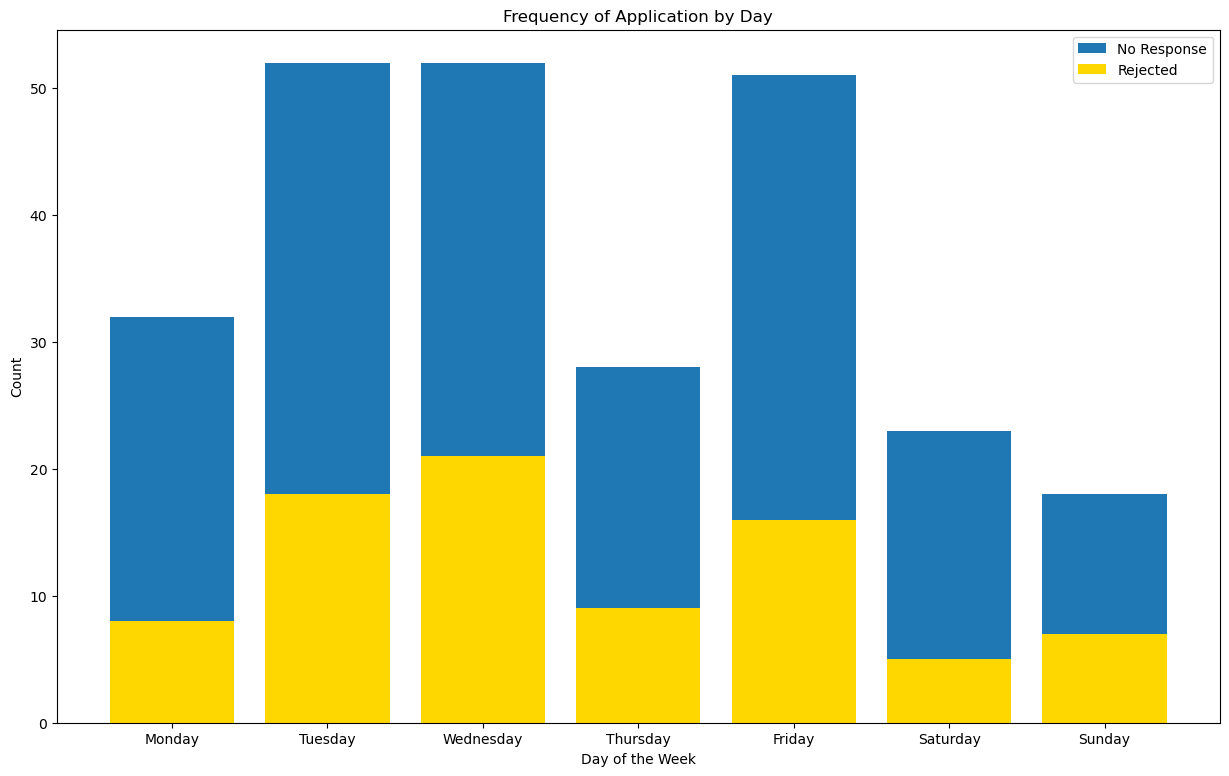

In [28]:
dow_apps = df[(df["Result"] == "No Response") | (df["Result"] == "Rejected")].groupby("DOW").count()["Result"].sort_index(key=lambda d: d.map(DOW_dict))
dow_rej = df[df["Result"] == "Rejected"].groupby("DOW").count()["Result"].sort_index(key=lambda d: d.map(DOW_dict))

fig, ax = plt.subplots(1,1, figsize=(15,9))

ax.bar(x=dow_apps.index, height=dow_apps, label="No Response")
ax.bar(x=dow_rej.index, height=dow_rej, color="Gold", label="Rejected")

ax.set_ylabel("Count")
ax.set_xlabel("Day of the Week")
ax.set_title("Frequency of Application by Day")
ax.legend()

<AxesSubplot: xlabel='DOW'>

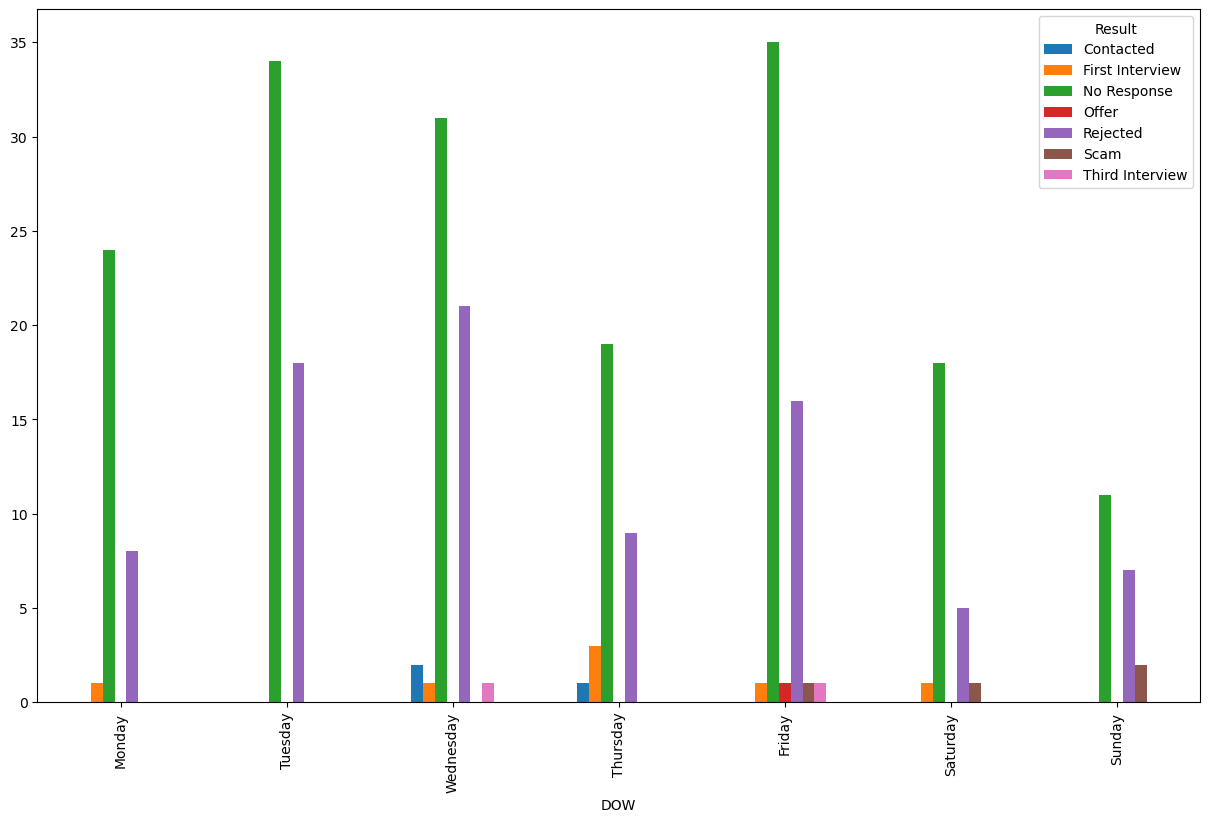

In [29]:
dow_group = df.groupby(["DOW", "Result"]).size().unstack().sort_index(key=lambda d: d.map(DOW_dict))
dow_group.plot.bar(figsize=(15,9))


## Applications over Time

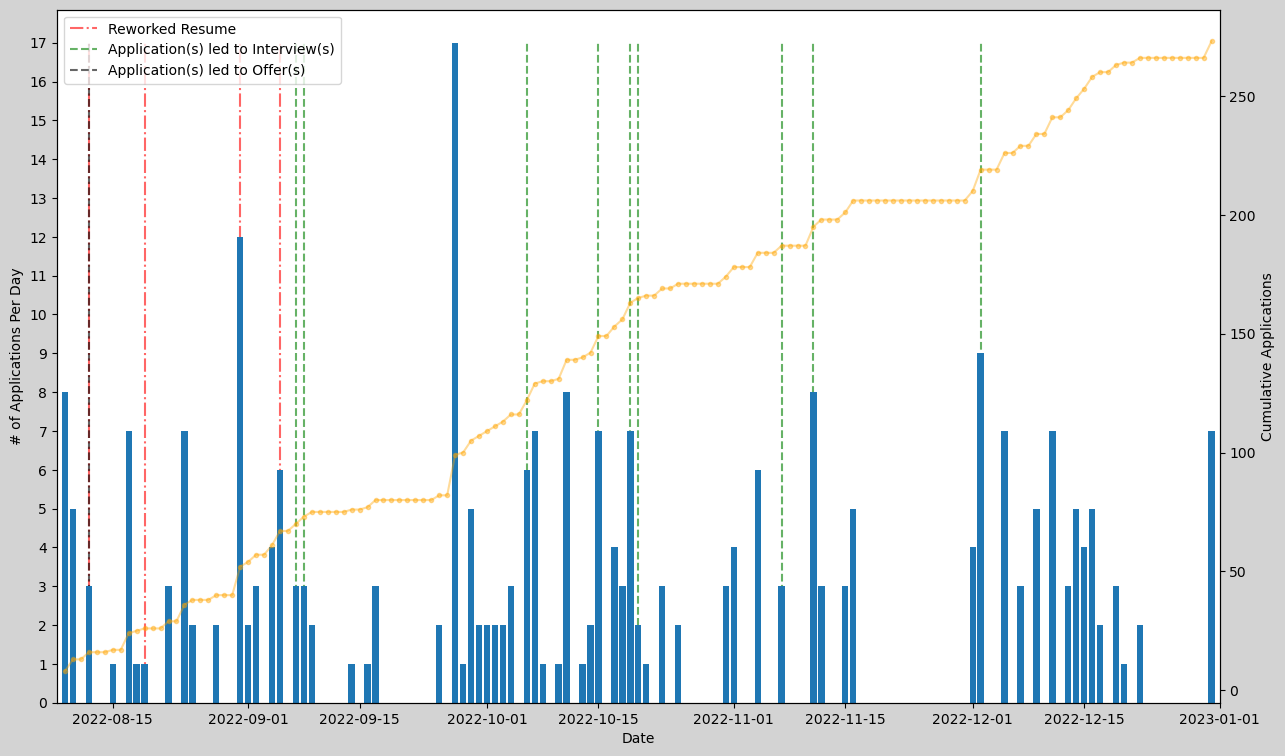

In [30]:
date_count = df.groupby("Date_Applied").size().reindex(pd.date_range(df["Date_Applied"].min(), df["Date_Applied"].max()), fill_value=0)

fig, ax = plt.subplots(figsize=(15,9))
fig.patch.set_facecolor('lightgray')

resume_dates = ["2022-08-12", "2022-08-19", "2022-08-31", "2022-09-05"]
interview_dates = df["Date_Applied"][df["Result"].str.contains("(?i)Interview")].values
offer_dates = df["Date_Applied"][df["Result"].str.contains("Offer")].values

ax_cumsum = ax.twinx()

ax.bar(date_count.index, date_count.values, zorder=2)
ax_cumsum.plot(date_count.cumsum().index, date_count.cumsum().values, c="orange", marker=".", alpha=0.4, zorder=2)

ax.set_ylabel("# of Applications Per Day")
ax_cumsum.set_ylabel("Cumulative Applications")

ax.set_xlabel("Date")
ax_cumsum.set_xlabel("Date")

ax.set_yticks(range(date_count.min(), date_count.max()+1))
ax.set_xlim([date_count.index.min() - pd.Timedelta(1, unit='d'), date_count.index.max() + pd.Timedelta(1, unit='d')])

# resume restructure
ax.vlines(resume_dates, ymin=date_count.min(), ymax=date_count.max(), linestyle="dashdot", color="red", label="Reworked Resume", alpha=0.6, zorder=1)

# interviews
ax.vlines(interview_dates, ymin=date_count.min(), ymax=date_count.max(), linestyle="dashed", color="green", label="Application(s) led to Interview(s)", alpha=0.6, zorder=1)

# offers
ax.vlines(offer_dates, ymin=date_count.min(), ymax=date_count.max(), linestyle="dashed", color="black", label="Application(s) led to Offer(s)", alpha=0.6, zorder=1)

ax.legend(loc="upper left")

In [31]:
date_count

2022-08-09    8
2022-08-10    5
2022-08-11    0
2022-08-12    3
2022-08-13    0
             ..
2022-12-27    0
2022-12-28    0
2022-12-29    0
2022-12-30    0
2022-12-31    7
Freq: D, Length: 145, dtype: int64

## Response Pie Charts

Text(0.5, 1.0, 'Results of Responses')

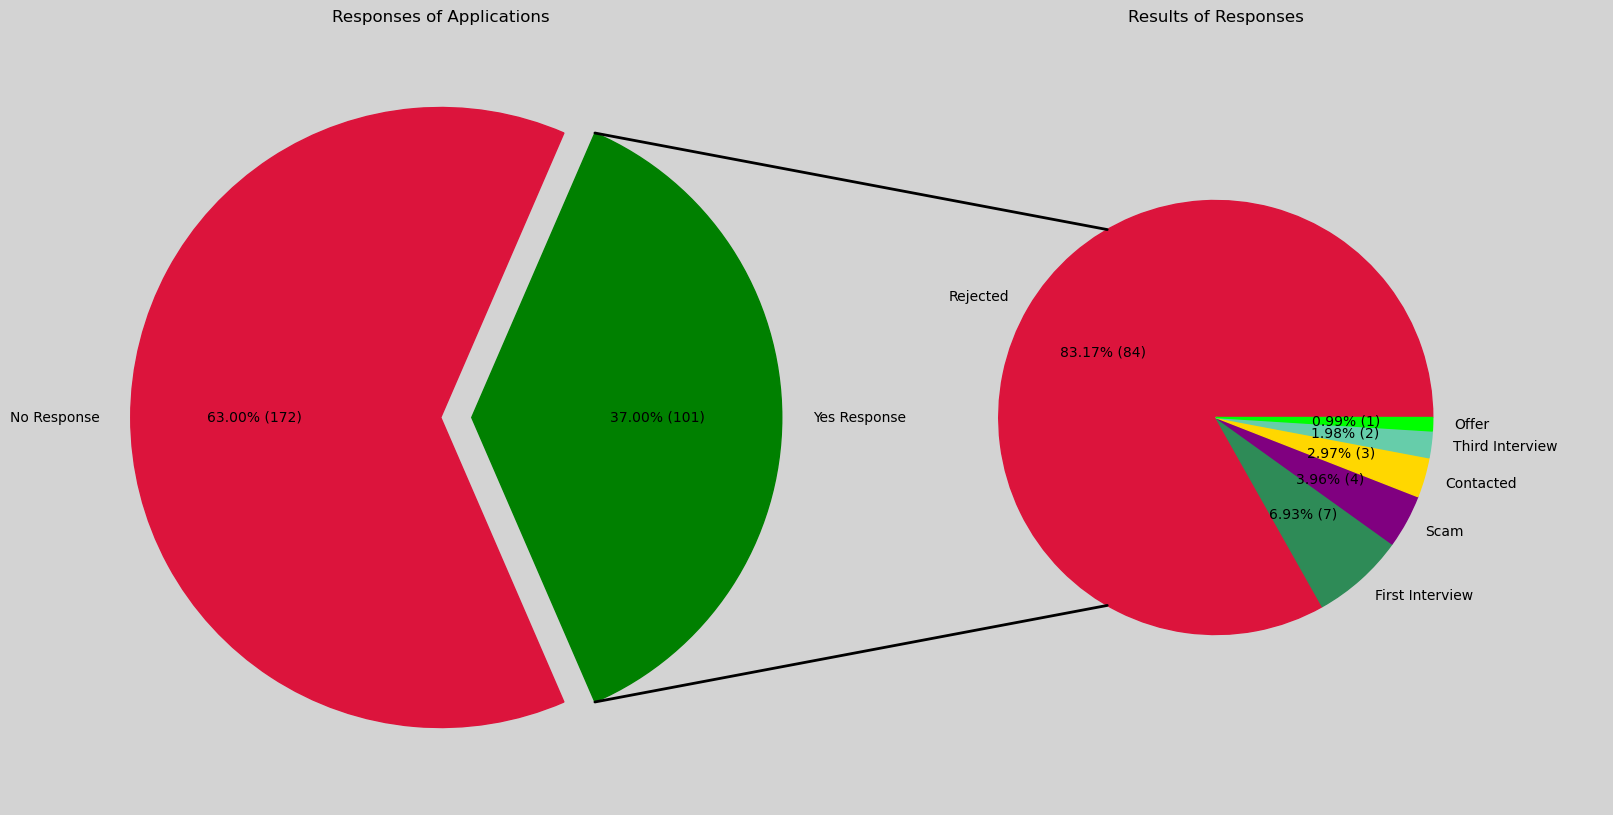

In [32]:
def pie_fmt(wedge_ratio):
    return "{:.2f}% ({:.0f})".format(wedge_ratio, total*wedge_ratio/100)

main_colors = {"No Response": "crimson",
               "Yes Response": "green"}

sub_colors = {"Rejected": "crimson",
              "Contacted": "gold",
              "First Interview": "seagreen",
              "Second Intervew": "mediumseagreen",
              "Third Interview": "mediumaquamarine",
              "Offer": "lime",
              "Scam": "purple"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))
fig.subplots_adjust(wspace=0)
fig.patch.set_facecolor('lightgray')

woi = "Yes Response"
explosion_size = 0.1

color_map = {"Rejected": "Red",
            "Scam": "Orange",
            "Contacted": "Yellow"}

response_binary = df["Result"].where(df["Result"] == "No Response", "Yes Response")

pie_data = response_binary
subpie_data = df["Result"][df["Result"] != "No Response"]

## setting up pie chart

# ratios
ratios = pie_data.value_counts() / len(pie_data)

# labels
labels = pie_data.value_counts().index

# get explosions and angle for wedge of interest
explode = [explosion_size if label == woi else 0.0 for label in labels]
angle = 180 * ratios[woi]

# plot pie
total = len(pie_data)
wedges, cats, texts = ax1.pie(pie_data.value_counts(), autopct=pie_fmt, labels=pie_data.value_counts().index, explode=explode, startangle=angle, textprops={'fontsize': 10})

## setting up sub-pie chart

# ratios
ratios = subpie_data.value_counts() / len(subpie_data)

# labels and sizes
labels = subpie_data.value_counts().index

# plot subpie
total = len(subpie_data)
subwedges, subcats, subtexts = ax2.pie(subpie_data.value_counts(), autopct=pie_fmt, labels=subpie_data.value_counts().index, radius=0.7, textprops={'fontsize': 10})


## connecting
# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r

subcenter, subr = subwedges[0].center, subwedges[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-subr*np.cos(np.pi / 180 * 60), subr*np.sin(np.pi / 180 * 60)), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)

con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-subr*np.cos(np.pi / 180 * 60), -subr*np.sin(np.pi / 180 * 60)), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)

con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

color_seq = [main_colors[cat.get_text()] for cat in cats]

for color, wedge in zip(color_seq, wedges):
    wedge.set_color(color)
    
color_seq = [sub_colors[subcat.get_text()] for subcat in subcats]

for color, subwedge in zip(color_seq, subwedges):
    subwedge.set_color(color)
    
ax1.set_title("Responses of Applications")
ax2.set_title("Results of Responses")

## Applications by Broad Position Title

In [33]:
df_title = df["Title"]

dse_match = "(?i)Data Scientist|Data Science|Science|Scientist"
da_match = "(?i)Data Analyst|Data Analytics|Analytics|Analyst"
ml_match = "(?i)Machine Learning Engineer|Machine Learning"
de_match = "(?i)Data Engineer|Engineer|Engineering|Database"

# fixing overlaps
dse_series = df_title[df_title.str.contains(dse_match)]

ml_series = df_title[df_title.str.contains(ml_match)]
de_series = df_title[df_title.str.contains(de_match)]
de_series = de_series[(~de_series.isin(ml_series)) & (~de_series.isin(dse_series))]

da_series = df_title[df_title.str.contains(da_match)]
da_series = da_series[(~da_series.isin(dse_series)) & (~da_series.isin(de_series)) & (~da_series.isin(ml_series))]

other_series = df_title[~((df_title.str.contains(dse_match)) | (df_title.str.contains(da_match)) | (df_title.str.contains(ml_match)) | (df_title.str.contains(de_match)))]

In [34]:
other_series

0               Data Insights (Games) -
48                      Data Specialist
73         Tecdp 2023 - Wordlebitch123$
97       Intern, Quantitative Developer
103                         Data Intern
110                          Nlp Intern
114            Statistical Programmer -
201    Data Associate - Wordlebitch123$
243           Data Ingestion Specialist
250                     Data Specialist
266                     Data Specialist
Name: Title, dtype: object

In [35]:
df["Broad_Role"] = pd.Series("Data Scientist", dse_series.index).combine_first(pd.Series("Data Analyst", da_series.index)) \
    .combine_first(pd.Series("Data Engineer", de_series.index)) \
    .combine_first(pd.Series("ML Engineer", ml_series.index)) \
    .combine_first(pd.Series("Other", other_series.index))

In [36]:
df.head()

,Date_Applied,Line,Company,Title,Result,DOW,Broad_Role
0,2022-08-09,NYT: Data Insights (Games) - wordleBitch123$\n,NYT,Data Insights (Games) -,No Response,Tuesday,Other
1,2022-08-09,"SPOTIFY: Data Scientist, Spotify for Artists =...",SPOTIFY,"Data Scientist, Spotify For Artists",Rejected,Tuesday,Data Scientist
2,2022-08-09,DOW JONES: Data Analyst - wordleBitch123$\n,DOW JONES,Data Analyst -,No Response,Tuesday,Data Analyst
3,2022-08-09,MANTECH: Data Science/Analytics New Graduate -...,MANTECH,Data Science/Analytics Ne,No Response,Tuesday,Data Scientist
4,2022-08-09,OSCAR HEALTH: Data Scientist\n,OSCAR HEALTH,Data Scientist,No Response,Tuesday,Data Scientist


<AxesSubplot: xlabel='Broad_Role'>

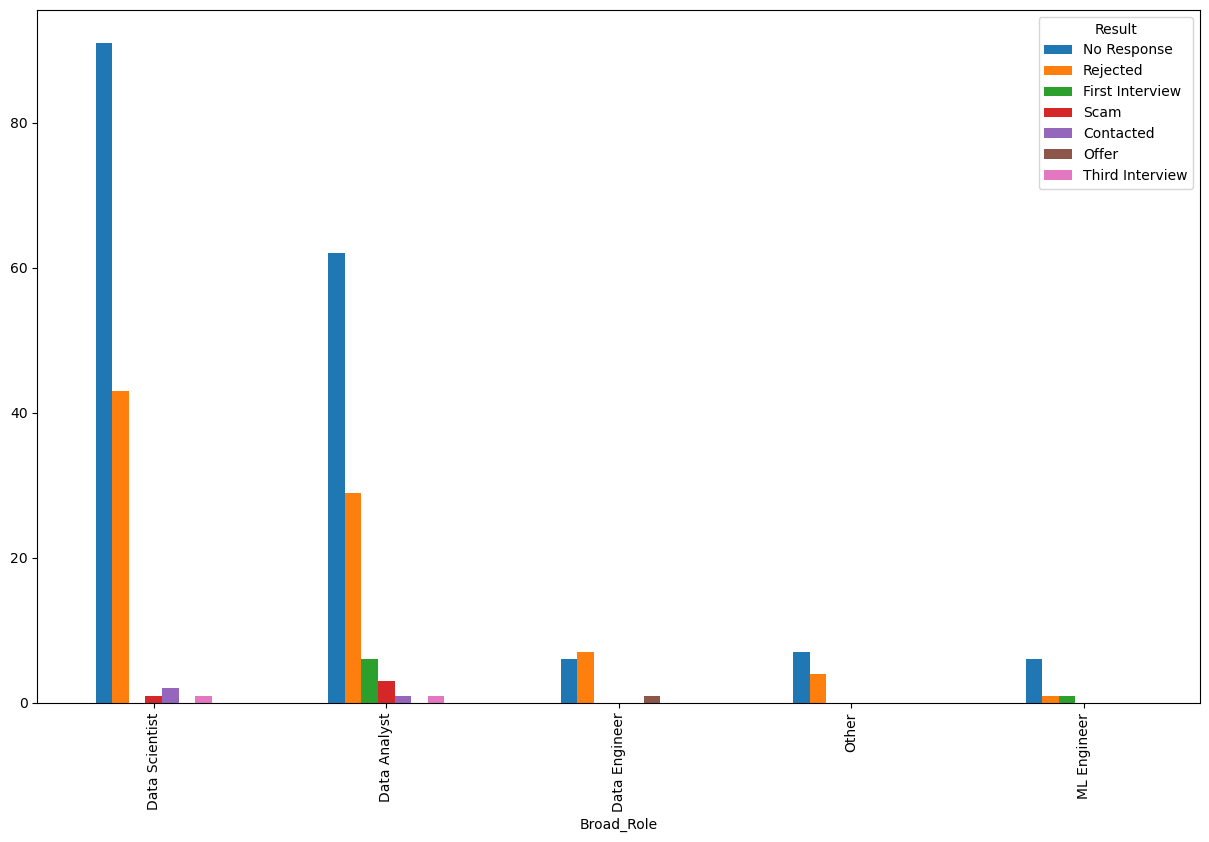

In [62]:
role_group = df.groupby(["Broad_Role", "Result"]).size().unstack()

# sort values by row sums and then plot
role_group.assign(temp_sum=role_group.sum(axis=1)) \
    .sort_values(by="temp_sum", ascending=False).iloc[:,:-1] \
    .reindex(role_group.mean(axis=0).sort_values(ascending=False).index, axis=1) \
    .plot.bar(figsize=(15,9))

In [58]:
role_group.assign(temp_sum=role_group.sum(axis=1)).sort_values(by="temp_sum", ascending=False).iloc[:,:-1]

Result,No Response,Rejected,First Interview,Scam,Contacted,Offer,Third Interview
Broad_Role,,,,,,,
Data Scientist,91.0,43.0,NaN,1.0,2.0,NaN,1.0
Data Analyst,62.0,29.0,6.0,3.0,1.0,NaN,1.0
Data Engineer,6.0,7.0,NaN,NaN,NaN,1.0,NaN
Other,7.0,4.0,NaN,NaN,NaN,NaN,NaN
ML Engineer,6.0,1.0,1.0,NaN,NaN,NaN,NaN


Index(['No Response', 'Rejected', 'First Interview', 'Scam', 'Contacted',
       'Offer', 'Third Interview'],
      dtype='object', name='Result')

## Monthly Applications

In [39]:
df["year-month"] = df["Date_Applied"].dt.to_period("M")

<AxesSubplot: xlabel='year-month'>

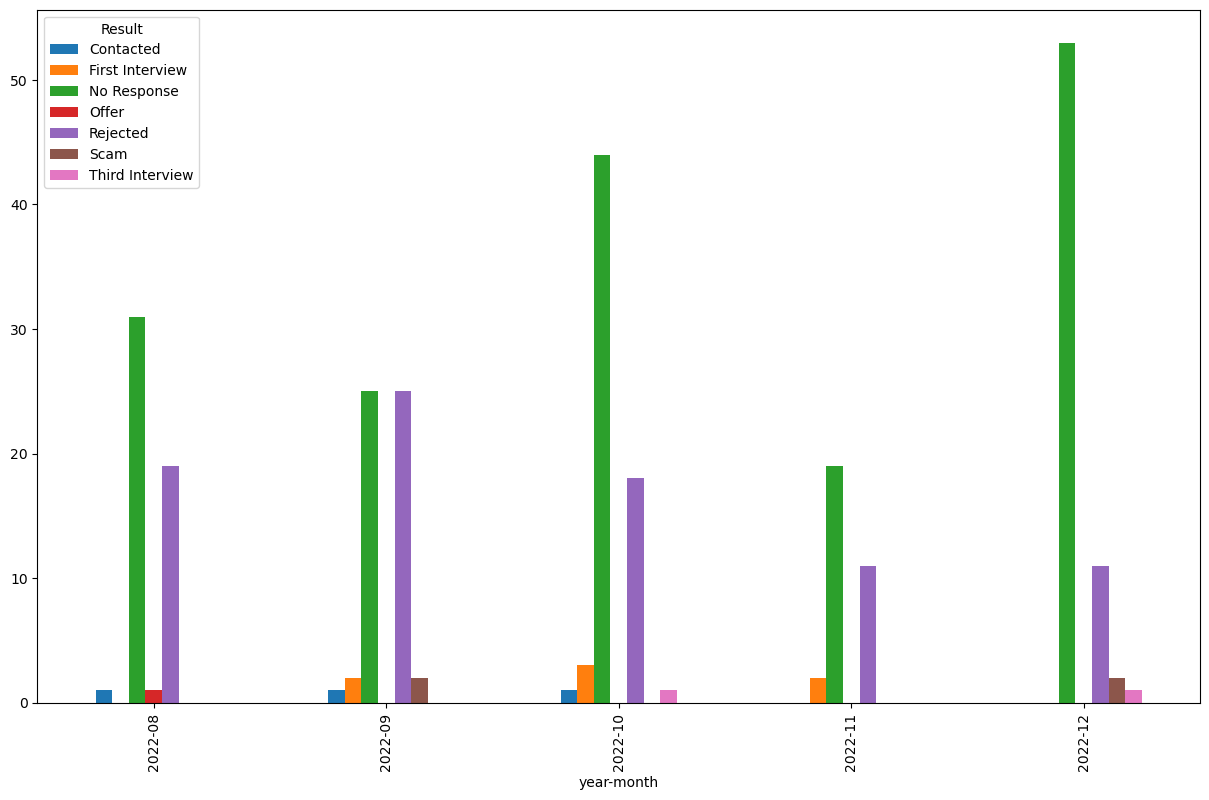

In [40]:
month_group = df.groupby(["year-month", "Result"]).size().unstack()

month_group.plot.bar(figsize=(15,9))

<AxesSubplot: xlabel='year-month'>

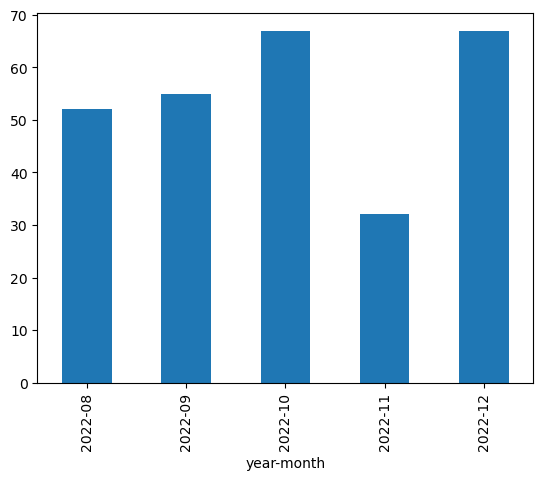

In [41]:
month_group.sum(axis=1).plot.bar()